# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>Intro to MLOps: Experiment Tracking with Comet ML & Pytorch</b></p>

![](https://github.com/TirendazAcademy/End-to-End-Deep-Learning-Projects/blob/main/image_classification_pytorch_comet/Images/images/dog-cat.png?raw=true)


This notebook walks you through how to build a CNN model for image classification with PyTorch and track an experiment with Comet.

<b>Table of contents:</b>
<ul>
<li><a href="#Introduction">Introduction</a></li>  
<li><a href="#Understanding">Understanding the dataset</a></li>         
<li><a href="#Loading-image-data">Loading image data</a></li>
<li><a href="#Building">Model building</a></li>
<li><a href="#Prediction">Make a prediction</a></li>
<li><a href="#Conclusion">Conclusion</a></li>
</ul>

Let's dive in!

<a id="Introduction"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>1. Introduction</b></p>

Before I start the analysis, let me explain what Pytorch and Comet are.

## What is Pytorch?

![](https://github.com/TirendazAcademy/End-to-End-Deep-Learning-Projects/blob/main/image_classification_pytorch_comet/Images/images/pytroch_features.png?raw=true)

PyTorch is a machine learning framework based on the Torch library, used for applications such as computer vision and NLP. PyTorch is a great choice for deep learning projects because of its flexibility, ease of use, and strong community support.

## What is Comet ML?

![](https://github.com/TirendazAcademy/Comet-ML-Tutorials/blob/main/Images/comet-ml.png?raw=true)

Comet ML is a platform that allows developers and data scientists to track, compare, and optimize their machine learning experiments. It provides a simple interface to log code, metrics, and artifacts, and allows users to collaborate and share their work with others.

Now, let's start an experiment with the Comet API key and log the hyperparameters we'll use for deep learning architecture. To do this, I'm going to use kaggle secret feature first as shown below:

In [1]:
# Setup user secrets for login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
my_api_key = user_secrets.get_secret("COMET_API_KEY")


#Install comet_ml
!pip install comet_ml

# import comet_ml at the top of your file
import comet_ml
from comet_ml import Experiment

## Create an experiment with your API key
experiment = Experiment(
    api_key= my_api_key,
    workspace="tirendaz-academy",
    project_name="experiment-tracking")

# Setting hyperparameters
hyper_params = {"seed": 42, "batch_size": 32, "num_epochs": 20, "learning_rate": 1e-3,"image_size": 224}
experiment.log_parameters(hyper_params)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.7/462.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.4/504.4 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/tirendaz-academy/experiment-tracking/90544383c2e6489094457ab9aac4afb9



Let's take a look at the version of the torch and check if Cuda exists.

In [2]:
import torch
from torch import nn

# Make sure: torch >= 1.10.0
print("The version of torch:", torch.__version__)

# Setting device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("The type of devise: ",device)

The version of torch: 1.11.0
The type of devise:  cuda


The dataset we will use for this tutorial is the cat and dog dataset, which contains images of cats and dogs. Let's take a look at the files in the dataset folder. To do this, let me create a function. 

In [3]:
# Looking inside files
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
image_path = "/kaggle/input/cat-and-dog"
walk_through_dir(image_path)

There are 2 directories and 0 images in '/kaggle/input/cat-and-dog'.
There are 1 directories and 0 images in '/kaggle/input/cat-and-dog/test_set'.
There are 2 directories and 0 images in '/kaggle/input/cat-and-dog/test_set/test_set'.
There are 0 directories and 1013 images in '/kaggle/input/cat-and-dog/test_set/test_set/dogs'.
There are 0 directories and 1012 images in '/kaggle/input/cat-and-dog/test_set/test_set/cats'.
There are 1 directories and 0 images in '/kaggle/input/cat-and-dog/training_set'.
There are 2 directories and 0 images in '/kaggle/input/cat-and-dog/training_set/training_set'.
There are 0 directories and 4006 images in '/kaggle/input/cat-and-dog/training_set/training_set/dogs'.
There are 0 directories and 4001 images in '/kaggle/input/cat-and-dog/training_set/training_set/cats'.


Nice! We saw the files in the dataset folder. Now let's create train and testing paths:

In [4]:
# Creating our paths
my_train_dir = "/kaggle/input/cat-and-dog/training_set/training_set"
my_test_dir = "/kaggle/input/cat-and-dog/test_set/test_set"
my_train_dir, my_test_dir

('/kaggle/input/cat-and-dog/training_set/training_set',
 '/kaggle/input/cat-and-dog/test_set/test_set')

<a id="Understanding"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>2. Understanding the Dataset</b></p>

It is important to understand the dataset for deep learning analysis because the dataset is the foundation of any machine learning or deep learning model. A deep learning model can only be as good as the data it is trained on, and a poor understanding of the dataset can lead to poor model performance or even bias. Now let's take a look at an image in the dataset. 

Random image path: /kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4202.jpg
Image class: cats
Image height: 217
Image width: 179


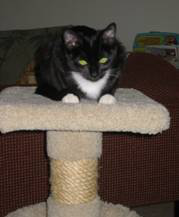

In [5]:
import random
from PIL import Image
import glob
from pathlib import Path

# Setting seed
random.seed(hyper_params["seed"]) 

# Creating our image path
image_path= glob.glob(f"{image_path}/*/*/*/*.jpg")

# Getting random a path
random_image_path = random.choice(image_path)

# Creating a variable for the path 
image_class = Path(random_image_path).parent.stem

# Let's open the image
image = Image.open(random_image_path)

# Let's print our metadata
print("Random image path: {}".format(random_image_path))
print("Image class: {}".format(image_class))
print("Image height: {}".format(image.height)) 
print("Image width: {}".format(image.width))
image

Beautiful cute cat isn't it? I love cats. So can't we use matplotlib for data visualization? Definitely yes. Let me show you.

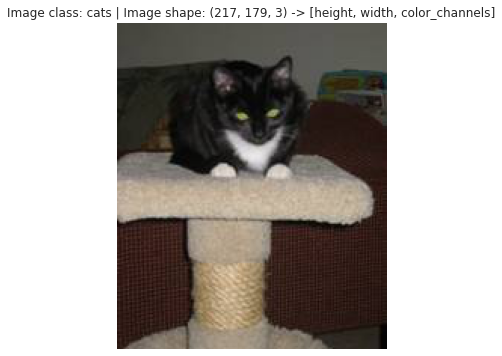

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Convert the image to an array
img_as_array = np.asarray(image)

# Plotting the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

<a id="Loading-image-data"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>3. Loading Image Data</b></p>
So far, we've taken a look at the dataset. We are ready to load our dataset using this function. The easiest way to load data is to use the `ImageFolder` function in PyTorch. Let's load the dataset with this function. First, we're going to use data augmentation. Data augmentation is a technique used to artificially increase the size of a dataset by applying random modifications to the existing data. 

In [7]:
from torchvision import transforms

# Setting our image size
IMAGE_SIZE=(hyper_params["image_size"], hyper_params["image_size"])

# Creating a transform for training using TrivialAugment
my_train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

# Creating a transform for testing 
my_test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

Let's load images from train and test folders into a PyTorch dataset with the `ImageFolder` function.

In [8]:
# Converting our image folders ito Datasets
from torchvision import datasets

# Converting our image folders ito Datasets
my_train_data = datasets.ImageFolder(my_train_dir, transform=my_train_transform)
my_test_data = datasets.ImageFolder(my_test_dir, transform=my_test_transform)

my_train_data, my_test_data

(Dataset ImageFolder
     Number of datapoints: 8005
     Root location: /kaggle/input/cat-and-dog/training_set/training_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2023
     Root location: /kaggle/input/cat-and-dog/test_set/test_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

Now let's turn Datasets into DataLoader's.

In [9]:
from torch.utils.data import DataLoader

# Setting some parameters
torch.manual_seed(hyper_params["seed"])
NUM_WORKERS = os.cpu_count()

# Creating a training DataLoader
my_train_dataloader = DataLoader(my_train_data,
                                 batch_size=hyper_params["batch_size"], 
                                 shuffle=True,
                                 num_workers=NUM_WORKERS)

# Creating a test DataLoader
my_test_dataloader = DataLoader(my_test_data,
                               batch_size=hyper_params["batch_size"], 
                               shuffle=False, 
                               num_workers=NUM_WORKERS)

my_train_dataloader, my_test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f443b067bd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f443b067b10>)

Nice! We created the `DataLoader` objects. Let's go ahead and build an image classification architecture.

<a id="Building"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>4. Model Building</b></p>

To build our model, we're going to use an architecture based on convolutional neural network (CNN). The architecture of a CNN consists of several layers, including convolutional layers, pooling layers, and fully connected layers.

In [10]:
# Creating a CNN-based image classifier.
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, 512, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2)) 
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=512*3*3, out_features=2))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x

    # Instantiate an object.
my_model = ImageClassifier().to(device)

Ok, we created a CNN-based model. But does this model work? To understand this, let's pass a image through the model.

In [11]:
# Let's get a batch of images and labels 
img_batch, label_batch = next(iter(my_train_dataloader))

# Let's get a single image from the batch and then unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# Let's perform a forward pass on a single image
my_model.eval()
with torch.inference_mode():
    pred = my_model(img_single.to(device))
    
# Let's print out the results
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[-0.0116, -0.0099]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4996, 0.5004]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
1


Nice! Our model is working for an image. Let's go ahead and try to understand this model with the `torchinfo` package 

In [12]:
# Install and importing torchinfo
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary

# Testing with an example input size 
summary(my_model, input_size=[1, 3, hyper_params["image_size"] ,hyper_params["image_size"]]) 

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─BatchNorm2d: 2-3                  [1, 64, 224, 224]         128
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 512, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 512, 112, 112]        295,424
│    └─ReLU: 2-6                         [1, 512, 112, 112]        --
│    └─BatchNorm2d: 2-7                  [1, 512, 112, 112]        1,024
│    └─MaxPool2d: 2-8                    [1, 512, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 512, 56, 56]          2,359,

Note that the model is built on the training data and tested on the validation set. Now let's create two function to train and test the model.

In [13]:
def my_train_step(model: torch.nn.Module, 
                 dataloader: torch.utils.data.DataLoader, 
                 loss_fn: torch.nn.Module, 
                 optimizer: torch.optim.Optimizer):
    
    # Setting train mode
    my_model.train()
    
    # Initializing train loss & train accuracy values
    train_loss = 0
    train_acc = 0
    
    # Looping through each batch data in the dataloader
    for batch, (inp, out) in enumerate(dataloader):
        
        # Moving data to device
        inp, out = inp.to(device), out.to(device)
        
        # Predicting the input
        y_pred = my_model(inp)

        # Calculating & accumulating loss
        loss = loss_fn(y_pred, out)
        train_loss += loss.item() 

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Calculating & accumulating the accuracy metric
        y_pred_label = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_label == out).sum().item()/len(y_pred)

    # Calculating metrics 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    # Logging train metrics
    experiment.log_metrics({"train_accuracy": train_acc, "train_loss": train_loss}, epoch=hyper_params['num_epochs'])
    
    return train_loss, train_acc

In [14]:
def my_test_step(model: torch.nn.Module, 
                dataloader: torch.utils.data.DataLoader, 
                loss_fn: torch.nn.Module):
    
    # Setting eval mode
    my_model.eval() 
    
    # Initializing test loss & test accuracy values
    test_loss = 0
    test_acc = 0
    
    # Starting the inference mode
    with torch.inference_mode():
        
        # Looping through each batch data in the dataloader
        for batch, (inp, out) in enumerate(dataloader):
            
            # Moving data to device
            inp, out = inp.to(device), out.to(device)
    
            # Forward pass
            test_pred_logits = my_model(inp)

            # Calculating & accumulating loss
            loss = loss_fn(test_pred_logits, out)
            test_loss += loss.item()
            
            # Calculating & accumulating the accuracy metric
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == out).sum().item()/len(test_pred_labels))
            
    # Calculating metrics
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    # Logging test metrics
    experiment.log_metrics({"test_accuracy": test_acc, "test_loss": test_loss}, epoch=hyper_params['num_epochs'])
    
    return test_loss, test_acc

Now let's create a function named train to combine the train_step and test_step functions.

In [15]:
from tqdm.auto import tqdm

# Setting parameters 
def my_train(model: torch.nn.Module, 
            train_dataloader: torch.utils.data.DataLoader, 
            test_dataloader: torch.utils.data.DataLoader, 
            optimizer: torch.optim.Optimizer,
            loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
            epochs: int = 5):
    
    # Creating a variable for metrics
    my_results = {"train_loss": [],
                  "train_acc": [],
                  "test_loss": [],
                  "test_acc": []}
    
    # Looping for training and testing steps 
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = my_train_step(model=my_model,
                                              dataloader=my_train_dataloader,
                                              loss_fn=my_loss_fn,
                                              optimizer=my_optimizer)
        test_loss, test_acc = my_test_step(model=my_model,
                                           dataloader=my_test_dataloader,
                                           loss_fn=my_loss_fn)
        
        # Printing results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}")

        # Updating results
        my_results["train_loss"].append(train_loss)
        my_results["train_acc"].append(train_acc)
        my_results["test_loss"].append(test_loss)
        my_results["test_acc"].append(test_acc)

    # Returning results at the end of the epochs
    return my_results

So far, we created training and test steps. We are ready to train the model using these steps. Show time:

In [16]:
# Setting seeds
torch.manual_seed(hyper_params["seed"]) 
torch.cuda.manual_seed(hyper_params["seed"])

# Creating loss function & optimizer
my_loss_fn = nn.CrossEntropyLoss()
my_optimizer = torch.optim.Adam(params=my_model.parameters(), lr=hyper_params["learning_rate"])

# Initializing the timer
from timeit import default_timer as timer 
my_start_time = timer()

# Training our model
my_model_results = my_train(model=my_model,
                            train_dataloader=my_train_dataloader,
                            test_dataloader=my_test_dataloader,
                            optimizer=my_optimizer,
                            loss_fn=my_loss_fn,
                            epochs=hyper_params["num_epochs"])

# Ending the timer 
my_end_time = timer()

# Printing the time
print(f"Total training time: {my_end_time-my_start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9685 | train_acc: 0.5594 | test_loss: 0.7010 | test_acc: 0.5958
Epoch: 2 | train_loss: 0.9198 | train_acc: 0.5850 | test_loss: 0.6235 | test_acc: 0.6429
Epoch: 3 | train_loss: 0.7764 | train_acc: 0.6432 | test_loss: 0.6730 | test_acc: 0.6383
Epoch: 4 | train_loss: 0.6193 | train_acc: 0.6672 | test_loss: 0.5692 | test_acc: 0.7050
Epoch: 5 | train_loss: 0.5591 | train_acc: 0.7122 | test_loss: 0.5006 | test_acc: 0.7497
Epoch: 6 | train_loss: 0.5430 | train_acc: 0.7251 | test_loss: 0.5675 | test_acc: 0.6925
Epoch: 7 | train_loss: 0.5042 | train_acc: 0.7445 | test_loss: 0.5224 | test_acc: 0.7197
Epoch: 8 | train_loss: 0.4730 | train_acc: 0.7656 | test_loss: 0.5496 | test_acc: 0.7238
Epoch: 9 | train_loss: 0.4314 | train_acc: 0.7916 | test_loss: 0.3905 | test_acc: 0.8214
Epoch: 10 | train_loss: 0.4122 | train_acc: 0.8106 | test_loss: 0.3933 | test_acc: 0.8142
Epoch: 11 | train_loss: 0.3580 | train_acc: 0.8338 | test_loss: 0.3862 | test_acc: 0.8248
Epoch: 12 | train_l

Beautiful. It's done. Now we had a model for image classification. To understand the performance of model, let's visualize the loss and accuracy values.

In [17]:
def my_plot_loss_curves(results):
  
    my_results = dict(list(my_model_results.items()))

    # Getting the train & test loss values
    my_loss = my_results['train_loss']
    my_test_loss = my_results['test_loss']

    # Getting the train & test accuracy values
    my_accuracy = my_results['train_acc']
    my_test_accuracy = my_results['test_acc']

    # Calculating epochs
    my_epochs = range(len(my_results['train_loss']))

    # Let's setup a graph
    plt.figure(figsize=(15, 7))

    # Let's plot loss
    plt.subplot(1, 2, 1)
    plt.plot(my_epochs, my_loss, label='train_loss')
    plt.plot(my_epochs, my_test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Let' plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(my_epochs, my_accuracy, label='train_accuracy')
    plt.plot(my_epochs, my_test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

It is time to visualize for the loss and accuracy values using this function.

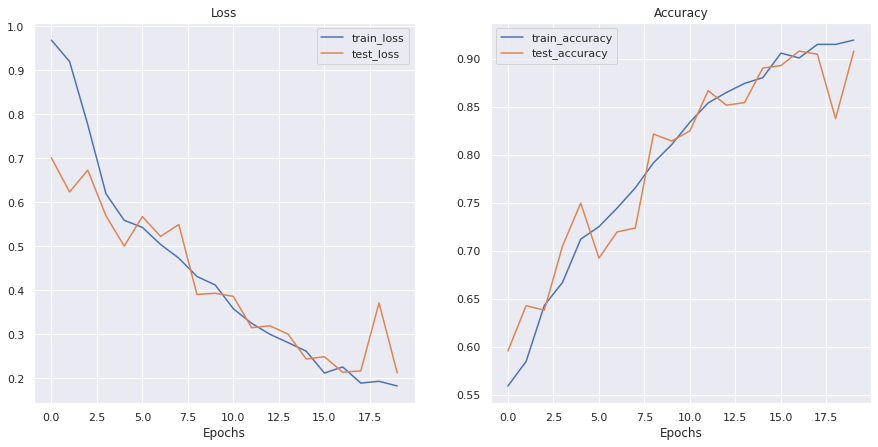

In [18]:
my_plot_loss_curves(my_model_results)

Awesome. The performance of our model is not bad on both the training and test datasets. Let's go ahead and take a look at how to make a prediction.

<a id="Prediction"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>5. Make a Prediction</b></p>

Now we had a good model for image classification. But, how does this model predict new data? To understand this let me make a prediction on a custom image. 

In [19]:
# Let's choose a image.
custom_image_path = "/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4001.jpg"

import torchvision
# Loading in custom image and turn the tensor values into float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Dividing the image pixel values by 255
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.4941, 0.3059, 0.3059,  ..., 0.5490, 0.5412, 0.5451],
         [0.5333, 0.3451, 0.3059,  ..., 0.5490, 0.5451, 0.5490],
         [0.5686, 0.3961, 0.2980,  ..., 0.5490, 0.5451, 0.5490],
         ...,
         [0.6157, 0.6039, 0.6314,  ..., 0.6392, 0.6157, 0.5961],
         [0.6157, 0.6039, 0.6314,  ..., 0.6471, 0.6157, 0.5882],
         [0.6157, 0.6039, 0.6314,  ..., 0.6471, 0.6118, 0.5804]],

        [[0.4314, 0.2431, 0.2392,  ..., 0.5490, 0.5412, 0.5451],
         [0.4863, 0.2941, 0.2549,  ..., 0.5490, 0.5451, 0.5490],
         [0.5412, 0.3686, 0.2706,  ..., 0.5490, 0.5451, 0.5490],
         ...,
         [0.4784, 0.4667, 0.4941,  ..., 0.5608, 0.5373, 0.5176],
         [0.4784, 0.4667, 0.4941,  ..., 0.5686, 0.5373, 0.5098],
         [0.4784, 0.4667, 0.4941,  ..., 0.5686, 0.5333, 0.5020]],

        [[0.3333, 0.1529, 0.1686,  ..., 0.5804, 0.5725, 0.5765],
         [0.4000, 0.2196, 0.1882,  ..., 0.5804, 0.5765, 0.5804],
         [0.4667, 0.2980, 0.2078,  ..

Now let's create transform pipleine to resize image.

In [20]:
custom_image_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
])

# Transforming target image
custom_image_transformed = custom_image_transform(custom_image)

# Printing out original and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 499, 421])
New shape: torch.Size([3, 224, 224])


First, let's fit the image for the model with the function we created and then make a prediction.

In [21]:
# Setting eval mode
my_model.eval()
with torch.inference_mode():
    
    # Adding an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Printing out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Predicting the labels of the image with an extra dimension
    custom_image_pred = my_model(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 224, 224])
Unsqueezed custom image shape: torch.Size([1, 3, 224, 224])


Now let's take a look at our model's predictions.

In [22]:
custom_image_pred

tensor([[-1.3649,  1.4751]], device='cuda:0')

Nice! we've seen the prediction values of the model. Let's take a look at the prediction class. First, let me show you the prediction values.

In [23]:
# Print out our prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits 
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction 
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-1.3649,  1.4751]], device='cuda:0')
Prediction probabilities: tensor([[0.0552, 0.9448]], device='cuda:0')
Prediction label: tensor([1], device='cuda:0')


It is time to find the predicted label.

In [24]:
class_names = my_train_data.classes
# Make sure to move the pred label to the CPU  
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] 
custom_image_pred_class

'dogs'

Let's visualize this image with matplotlib.

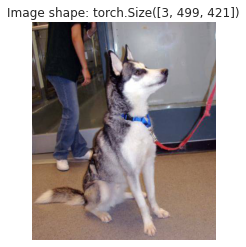

In [25]:
# Plotting custom image
# Make sure to permute image dimensions 
plt.imshow(custom_image.permute(1, 2, 0)) 
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [26]:
# Saving the model 
from comet_ml.integration.pytorch import log_model
log_model(experiment, my_model, model_name="My_Image_Classification_Model")

In [27]:
# Ending our experiment
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tirendaz-academy/experiment-tracking/90544383c2e6489094457ab9aac4afb9
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [502]          : (0.046953290700912476, 1.9028555154800415)
COMET INFO:     test_accuracy [20]  : (0.5958426339285714, 0.90771484375)
COMET INFO:     test_loss [20]      : (0.21237719245254993, 0.7010254412889481)
COMET INFO:     train_accuracy [20] : (0.5594123505976095, 0.9191982071713147)
COMET INFO:     train_loss [20]     : (0.1826288224767478, 0.968531524280153)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     image_size    : 224
COMET INFO:     learning_rate : 0.001
COMET INFO:     num_epochs    : 20
COMET INFO:     seed          : 42
COMET INFO:   Uploads:
COMET INFO:     conda-en

<a id="Conclusion"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>6. Conclusion</b></p>

In a nutshell, experiment tracking helps researchers to improve their models and to make data-driven decisions. In this notebook, you learned how to track an experiment with Comet ML and build an image classification model from scratch with Pytorch. Tensorflow is generally preferred for deep learning projects. However, with Pytorch, you can better control the deep-learning analysis steps. Pytorch has been preferred more recently, especially in the academic community. We also talked about data augmentation and highlighted the importance of this technique. I hope you like it. Let me know if you have any questions.

# Resources

- [Learn Pytorch](https://www.learnpytorch.io/)
- [Modern Computer Vision with PyTorch](https://www.amazon.com/Modern-Computer-Vision-PyTorch-applications/dp/1839213477)

📌 Thank you for reading 😀 If you like this notebook, don't forget to upvote it 😊

🔗 Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [Twitter](http://twitter.com/tirendazacademy) | [Instagram](https://www.instagram.com/tirendazacademy) |[GitHub](http://github.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) | [Kaggle](https://www.kaggle.com/tirendazacademy) 😎